# Multiple Time Series, Pre-trained Models and Covariates

This notebook serves as a tutorial for:
* Training a single model on multiple time series
* Using a pre-trained model to obtain forecasts for any time series unseen during training
* Training and using a model using covariates

First, some necessary imports:

In [23]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally
# fix_pythonpath_if_working_locally()
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.timeseries_generation import holidays_timeseries
import datetime
from evaluate_forecasts import darts_block_n_step_ahead_forecast

torch.manual_seed(1); np.random.seed(1)  # for reproducibility


### Read Data
Let's start by reading two time series - one containing the 60 min timeseries of nester and on the 15min

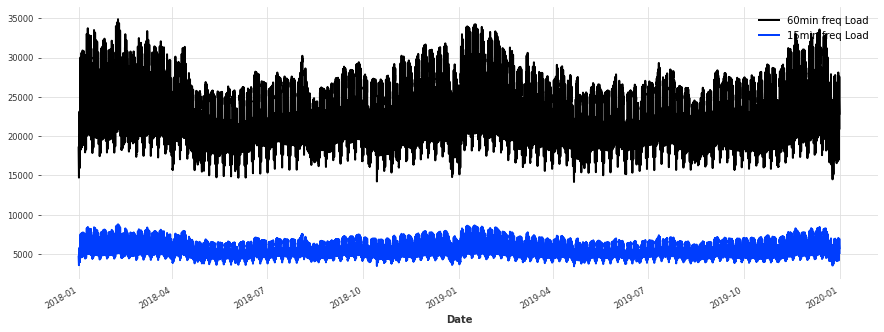

In [24]:
series_60 = TimeSeries.from_series(pd.read_csv(
    '../../RDN/Load Data (2018-2019)/artifacts/load_60min.csv', index_col=0, parse_dates=True), freq='H')

series_15 = TimeSeries.from_series(pd.read_csv(
    '../../RDN/Load Data (2018-2019)/artifacts/load_15min.csv', index_col=0, parse_dates=True), freq='15min')

plt.figure(figsize=(15,5))
series_60.plot(label='60min freq Load')
series_15.plot(label='15min freq Load')
plt.legend();


### Preprocessing
Usually neural networks tend to work better on normalised/standardised data. Here we'll use the `Scaler` class to normalise both of our time series between 0 and 1:

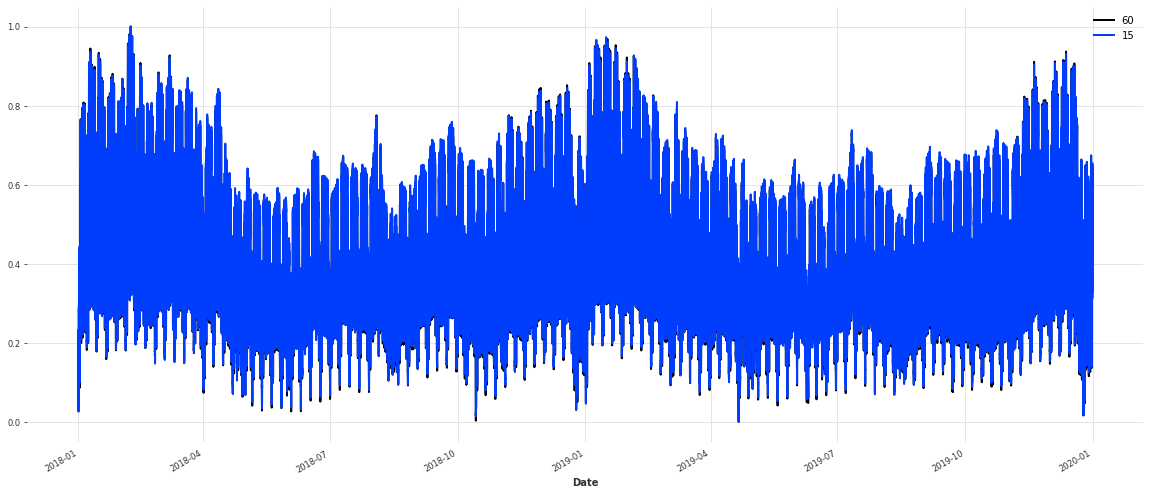

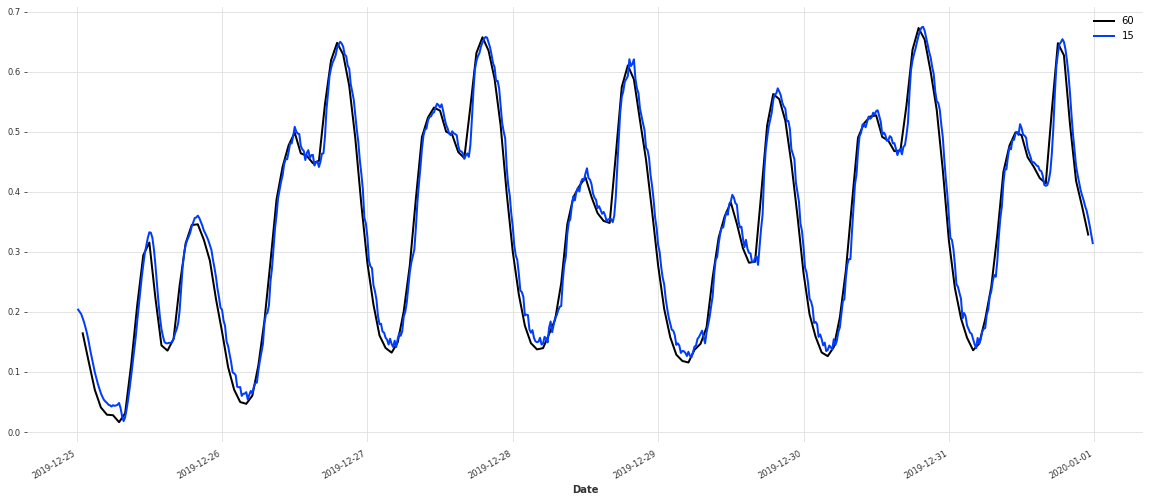

In [25]:
scaler_60, scaler_15 = Scaler(), Scaler()
series_60_scaled = scaler_60.fit_transform(series_60)
series_15_scaled = scaler_15.fit_transform(series_15)

plt.figure(figsize=(20, 8))
series_60_scaled.plot(label='60')
series_15_scaled.plot(label='15')
plt.legend()

plt.figure(figsize=(20,8))
series_60_scaled.drop_before(pd.Timestamp('20191225')).plot(label='60')
series_15_scaled.drop_before(pd.Timestamp('20191225')).plot(label='15')
plt.legend();


### Train / Validation split
Let's keep the 1st day of Dec as validation.

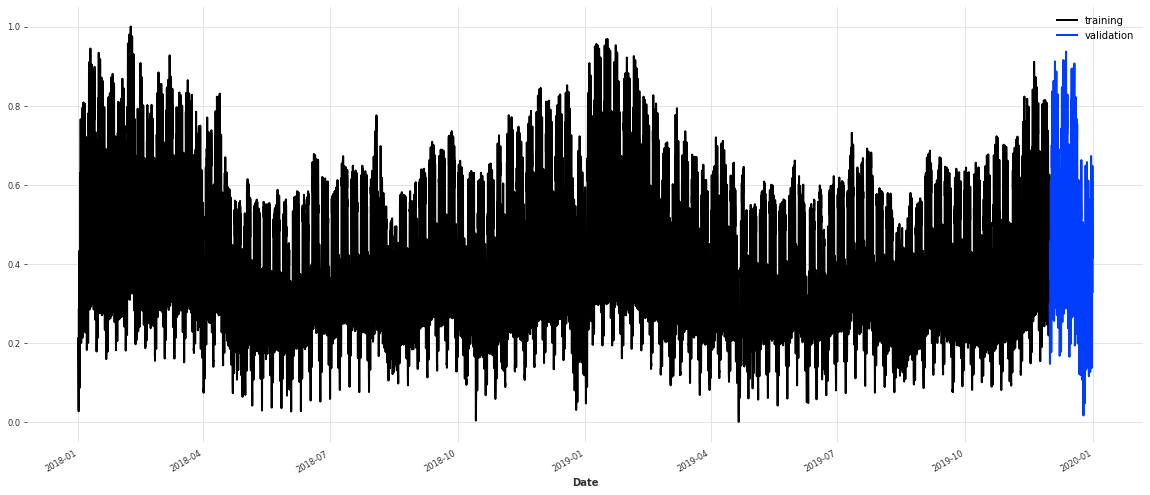

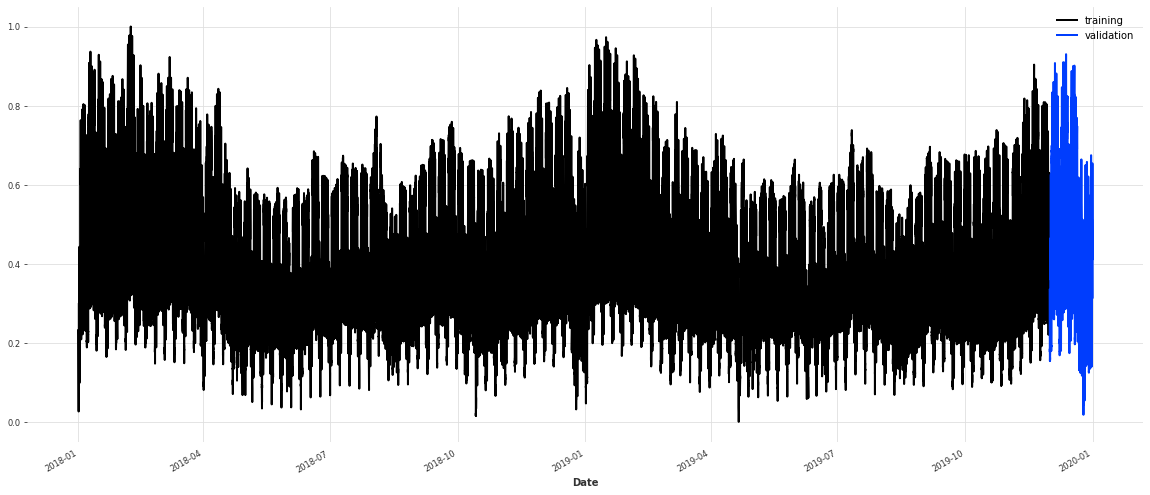

In [27]:
# split
last_train_day = '20191130'
first_val_day = '20201201'
train_60, val_60 = series_60_scaled.split_before(pd.Timestamp(first_val_day))
train_15, val_15 = series_15_scaled.split_before(pd.Timestamp(first_val_day))

# plot
plt.figure(figsize=(20, 8))
train_60.plot(label='training')
val_60.plot(label='validation')
plt.legend()

plt.figure(figsize=(20, 8))
train_15.plot(label='training')
val_15.plot(label='validation')
plt.legend()


## Global Forecasting Models
Darts contains many forecasting models, but not all of them can be trained on several time series. The models that support training on multiple series are called *global* models. At the time of writing, there are 5 global models:
* BlockRNNModel
* RNNModel
* Temporal Convolutional Networks (TCNs)
* N-Beats
* Transformer model

In the following, we will distinguish two sorts of time series:
* The **target time series** is the time series we are interested to forecast (given its history)
* A **covariate time series** is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It's sometimes also called *external data*.

We further differentiate covariates series, depending on whether they can be known in advance or not:
* **Past Covariates** denote time series whose past values are known at prediction time. These are usually things that have to be measured or observed.
* **Future Covariates** denote time series whose future values are already known at prediction time for the span of the forecast horizon. These can for instance represent known future holidays, or weather forecasts. 

Some models use only past covariates, others use only future covariates, and some models might use both. We will dive deeper in this topic in some other notebook, but for now it is enough to know this:
* `BlockRNNModel`, `TCNModel`, `NBEATSModel` and `TransformerModel` all use `past_covariates`.
* `RNNModel` uses `future_covariates`.

All of the global models listed above support training on multiple series. In addition, they also all support *multivariate series*. This means that they can seamlessly be used with time series of more than one dimension; the target series can contain one (as is often the case) or several dimensions. A time series with several dimensions is  really just a regular time series where the values at each time stamps are vectors instead of scalars.

As an example, the 4 models supporting `past_covariates` follow a "block" architecture. They contain a neural network that takes chunks of time series in input, and outputs chunks of (predicted) future time series values. The input dimensionality is the number of dimensions (components) of the target series, plus the number of components of all the covariates - stacked together. The output dimensionality is simply the number of dimensions of the target series:
![](static/images/global_io_covs.png)

The `RNNModel` works differently, in a recurrent fashion (which is also why they support future covariates).
The good news is that as a user, we don't have to worry too much about the different model types and input/output dimensionalities. The dimensionalities are automatically inferred for us by the model based on the training data, and the support for past or future covariates is simply handled by the `past_covariates` or `future_covariates` arguments. 

We'll still have to specify two important parameters when building our models:
* `input_chunk_length`: this is the length of the lookback window of the model; so each output will be computed by the model by reading the previous `input_chunk_length` points.
* `output_chunk_length`: this is the length of the outputs (forecasts) produced by the internal model. However, the `predict()` method of the "outer" Darts model (e.g., the one of `NBEATSModel`, `TCNModel`, etc) can be called for a longer time horizon. In these cases, if `predict()` is called for a horizon longer than `output_chunk_length`, the internal model will simply be called repeatedly, feeding on its own previous outputs in an auto-regressive fashion. If `past_covariates` are used it requires these covariates to be known for long enough in advance.

### Example with One Series
Let's look at a first example. We'll build an N-BEATS model that has a lookback window of 24 points (`input_chunk_length=24`) and predicts the next 12 points (`output_chunk_length=12`). We chose these values so it'll make our model produce successive predictions for one year at a time, looking at the past two years.

In [29]:
n_epochs = 200
forecast_horizon = 24
input_chunk_length = 24*14
random_state=0

model_60 = NBEATSModel(input_chunk_length=input_chunk_length, 
                       output_chunk_length=forecast_horizon, 
                       n_epochs=n_epochs, 
                       random_state=random_state,
                       torch_device_str='cuda',
                       model_name=f'N-beats_60min_20180101_{last_train_day}_lookback_{str(int(input_chunk_length/(24*7)))}_horizon_{str(int(forecast_horizon))}h_epochs_{str(n_epochs)}_random_state_{random_state}_plus_time')
model_60.fit(train_60, val_series=val_60, verbose=True)

[2021-10-21 12:40:42,116] INFO | darts.models.torch_forecasting_model | Train dataset contains 16417 samples.
[2021-10-21 12:40:42,116] INFO | darts.models.torch_forecasting_model | Train dataset contains 16417 samples.
[2021-10-21 12:40:42,180] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-21 12:40:42,180] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

And like any other Darts forecasting models, we can then get a forecast by calling `predict()`. Note that below, we are calling `predict()` with a horizon of 36, which is longer than the model internal `output_chunk_length` of 12. That's not a problem here - as explained above, in such a case the internal model will simply be called auto-regressively on its own outputs. In this case, it will be called three times so that the three 12-points outputs make up the final 36-points forecast - but all of this is done transparently behind the scenes.

loading model_best_50.pth.tar
MAPE = 4.93%


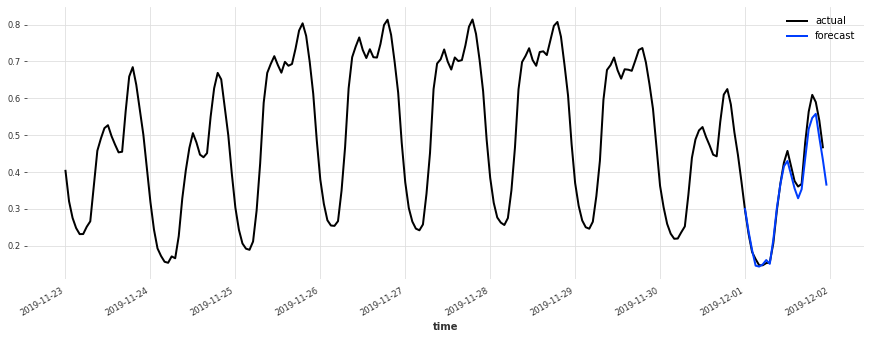

In [30]:
# load best
model_60 =  NBEATSModel.load_from_checkpoint(model_name=f'N-beats_60min_20180101_{last_train_day}_lookback_{str(int(input_chunk_length/(24*7)))}_horizon_{str(int(output_chunk_length))}h_epochs_{str(n_epochs)}_plus_time',
                                               work_dir='.darts', best=True)
pred = model_60.predict(n=forecast_horizon)

plt.figure(figsize=(15, 5))
series_60_scaled.drop_before(pd.Timestamp(pred.time_index[-1] - datetime.timedelta(days=9))).drop_after(pred.time_index[-1]).plot(label='actual')
pred.plot(label='forecast')
plt.legend()
print('MAPE = {:.2f}%'.format(mape(val_60, pred)))

### Training Process (behind the scenes)
So what happened when we called `model_60.fit()` above?

In order to train the internal neural network, Darts first makes a dataset of inputs/outputs examples from the provided time series (in this case: `series_60_scaled`). There are several ways this can be done and Darts contains a few different dataset implementations in the `darts.utils.data` package. 

By default, `NBEATSModel` will instantiate a `darts.utils.data.PastCovariatesSequentialDataset`, which simply builds all the consecutive p60s of input/output sub-sequences (of lengths `input_chunk_length` and `output_chunk_length`) existing in the series).

For an example series of length 14, with `input_chunk_length=4` and `output_chunk_length=2`, it looks as follows:
![](static/images/seq_dataset_one_ts.png)

For such a dataset, a series of length `N` would result in a "training set" of `N - input_chunk_length - output_chunk_length + 1` samples. In the toy example above, we have `N=14`, `input_chunk_length=4` and `output_chunk_length=2`, so the number of samples used for training would be K = 9. In this context, a training *epoch* consists in complete pass (possibly consisting of several mini-batches) over all the samples.

Note that different models are susceptible to use different datasets by default. For instance, `darts.utils.data.HorizonBasedDataset` is inspired by the [N-BEATS paper](https://arxiv.org/abs/1905.10437) and produces samples that are "close" to the end of the series, possibly even ignoring the beginning of the series.

If you have the need to control the way training samples are produced from `TimeSeries` instances, you can implement your own training dataset by inheriting the abstract `darts.utils.data.TrainingDataset` class. Darts datasets are inheriting from torch `Dataset`, which means it's easy to implement lazy versions that do not load all data in memory at once. Once you have your own instance of a dataset, you can directly call the `fit_from_dataset()` method, which is supported by all global forecasting models.

## Training a Model on Multiple Time Series
All this machinery can be seamlessly used with multiple time series. Here's how a sequential dataset with `input_chunk_length=4` and `output_chunk_length=2` looks for two series of lengths N and M:

![](static/images/seq_dataset_multi_ts.png)

Note a few things here:
* The different series do not need to have the same length, or even to share the same time stamps.
* In fact, they don't even need to have the same frequency.
* The total number of samples in the training dataset will be the union of all the training samples contained in each series; so a training epoch will now span all samples from all series.

In [ ]:
n_epochs = 200
forecast_horizon = 24
input_chunk_length = 24*14
random_state = 0

model_60_15 = NBEATSModel(input_chunk_length=input_chunk_length,
                       output_chunk_length=forecast_horizon,
                       n_epochs=n_epochs,
                       random_state=random_state,
                       torch_device_str='cuda',
                       model_name=f'N-beats_60_15min_20180101_{last_train_day}_lookback_{str(int(input_chunk_length/(24*7)))}_horizon_{str(int(forecast_horizon))}h_epochs_{str(n_epochs)}_random_state_{random_state}')
model_60_15.fit([train_60, train_15], val_series=val_60, verbose=True)


[2021-10-21 19:57:23,129] INFO | darts.models.torch_forecasting_model | Train dataset contains 133490 samples.
[2021-10-21 19:57:23,129] INFO | darts.models.torch_forecasting_model | Train dataset contains 133490 samples.
[2021-10-21 19:57:23,178] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-21 19:57:23,178] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/200 [00:00<?, ?it/s]

Then, fitting the model on two (or more) series is as simple as giving a list of series (instead of a single series) in argument to the `fit()` function:

### Producing Forecasts After the End of a Series

Now, importantly, when computing the forecasts we have to specify which time series we want to forecast the future for.

We didn't have this constraint earlier. When fitting models on one series only, the model remembers this series internally, and if `predict()` is called without the `series` argument, it returns a forecast for the (unique) training series. This does not work anymore as soon as a model is fit on more than one series - in this case the `series` argument of `predict()` becomes mandatory.

So, let's say we want to predict future of 60 load. In this case we specify `series=train_60` to the `predict()` function in order to say we want to get a forecast for what comes after `train_60`:

In [ ]:
# load best
model_60_15 =  NBEATSModel.load_from_checkpoint(model_name=f'N-beats_60_15min_20180101_{last_train_day}_lookback_{str(int(input_chunk_length/(24*7)))}_horizon_{str(int(output_chunk_length))}h_epochs_{str(n_epochs)}_random_state_{random_state}_plus_time',
                                               work_dir='.darts', best=True)
                                               
pred = model_60_15.predict(n=24, series=train_60)

plt.figure(figsize=(15, 5))
series_60_scaled.drop_before(pd.Timestamp(pred.time_index[-1] - datetime.timedelta(days=9))).drop_after(pred.time_index[-1]).plot(label='actual')
pred.plot(label='forecast')
plt.legend()
print('MAPE = {:.2f}%'.format(mape(val_60, pred)))

## Wait... does this mean that 15 consumption helps to predict 60 load??
Yes!!!!!


## Covariates Series

Until now, we have only been playing with models that only use the history of the *target* series to predict its future. However, as explained above, the global Darts models also support the use of *covariates* time series. These are time series of "external data", which we are not necessarily interested in predicting, but which we would still like to feed as input of our models because they can contain valuable information.

#### Building Covariates
Let's see a simple example with our 60 and 15 series, where we'll try to use the year and month-of-the-year and more as covariates:

In [ ]:
# time = pd.read_csv('../../RDN/Load Data (2018-2019)/artifacts/time_60min.csv', index_col=1, parse_dates=True)

# time_useful = time[['month_sin', 'month_cos', 
#                     'weekday_sin', 'weekday_cos',
#                     'hour_sin', 'hour_cos', 
#                     'holiday', 
#                     'monthday_sin', 'monthday_cos', 
#                     'yearday_cos', 'yearday_sin']]
# time_useful['holiday'] = time_useful['holiday'].astype(int)
# print(time_useful.head())

# build year and month series:
# ts1
year_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='year')
month_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='month', cyclic=True)
day_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='day', cyclic=True)
hour_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='hour', cyclic=True)
dayofweek_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='dayofweek')
dayofyear_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='dayofyear')
weekofyear_60 = datetime_attribute_timeseries(time_index=series_60_scaled, attribute='weekofyear')
holidays_60 = holidays_timeseries(time_index=series_60_scaled.time_index, country_code='PT')

covariates_60=year_60.stack(month_60) \
                     .stack(day_60) \
                     .stack(hour_60) \
                     .stack(dayofweek_60) \
                     .stack(dayofyear_60) \
                     .stack(weekofyear_60) \
                     .stack(holidays_60)

# scale them between 0 and 1:
scaler_dt_60 = Scaler()
covariates_60 = scaler_dt_60.fit_transform(covariates_60)

# ts2
year_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='year')
month_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='month', cyclic=True)
day_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='day', cyclic=True)
hour_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='hour', cyclic=True)
dayofweek_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='dayofweek')
dayofyear_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='dayofyear')
weekofyear_15 = datetime_attribute_timeseries(time_index=series_15_scaled, attribute='weekofyear')
holidays_15 = holidays_timeseries(time_index=series_15_scaled.time_index, country_code='PT')

covariates_15=year_15.stack(month_15) \
                     .stack(day_15) \
                     .stack(hour_15) \
                     .stack(dayofweek_15) \
                     .stack(dayofyear_15) \
                     .stack(weekofyear_15) \
                     .stack(holidays_15)

# scale them between 0 and 1:
scaler_dt_15 = Scaler()
covariates_15 = scaler_dt_15.fit_transform(covariates_15)
    

# split in train/validation sets:
train_covariates_60, val_covariates_60 = covariates_60.split_before(pd.Timestamp(first_val_day))
train_covariates_15, val_covariates_15 = covariates_15.split_before(pd.Timestamp(first_val_day))

# plot the covariates:
plt.figure(figsize=(25,10))
covariates_60.plot()
plt.title('load (60min) covariates (year and month)')

# plot the covariates:
plt.figure(figsize=(25, 10))
covariates_15.plot()
plt.title('load (15min) covariates (year and month)')


Good, so for each target series (60 and 15), we have built a covariates series having the same time axis and containing the year and the month.

Note that here the covariates series are **multivariate time series**: they contain two dimensions - one dimension for the year and one for the month.

### Training with Covariates
Let's revisit our example again, this time with covariates. We will build a `BlockRNNModel` here:

In [ ]:
n_epochs = 200
forecast_horizon = 24
input_chunk_length = 24*14
random_state = 0
model_cov = BlockRNNModel(model='LSTM', 
                          input_chunk_length=input_chunk_length, 
                          output_chunk_length=forecast_horizon, 
                          n_epochs=n_epochs, 
                          random_state=random_state,
                          torch_device_str='cuda',
                          model_name=f'BlockRNNModel_60_15min_20180101_{last_train_day}_lookback_{str(int(input_chunk_length/(24*7)))}_horizon_{str(int(forecast_horizon))}h_epochs_{str(n_epochs)}_random_state_{random_state}_plus_time')
model_cov.fit(series=[train_60, train_15], past_covariates=[train_covariates_60, train_covariates_15], verbose = True)

Now, to train the model with covariates, it is as simple as providing the covariates (in form of a list matching the target series) as `future_covariates` argument to the `fit()` function. The argument is named `future_covariates` to remind us that the model can use future values of these covariates in order to make a prediction.

### Forecasting with Covariates
similarly, getting a forecast is now only a matter of specifying the `future_covariates` argument to the `predict()` function.

In [ ]:
model_cov = BlockRNNModel.load_from_checkpoint(model_name=f'BlockRNNModel_60_15min_20180101_{last_train_day}_lookback_{str(int(input_chunk_length/(24*7)))}_horizon_{str(int(output_chunk_length))}h_epochs_{str(n_epochs)}_random_state_{random_state}_plus_time',
                                               work_dir='.darts', best=True)
pred_cov = model_cov.predict(n=forecast_horizon, 
                             series=train_60, 
                             past_covariates=covariates_60,
                             )

plt.figure(figsize=(15, 5))
series_60_scaled.drop_before(pd.Timestamp(pred.time_index[-1] - datetime.timedelta(days=9))).drop_after(pred.time_index[-1]).plot(label='actual')
pred_cov.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(val_60, pred_cov)))

Note that here we called `predict()` with a forecast horizon `n` that is larger than the `output_chunk_length` we trained our model with. We were able to do this because even though `BlockRNNModel` uses past covariates, in this case these covariates are also known into the future, so Darts is able to compute the forecasts auto-regressively for `n` time steps in the future.

### Backtesting with Covariates
We can also backtest the model using covariates. Say for instance we are interested in evaluating the running accuracy with a horizon of 12 months, starting at 75% of the 60 series:

  0%|          | 0/6986 [00:00<?, ?it/s]

[2021-10-21 12:36:34,040] ERROR | darts.metrics.metrics | ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

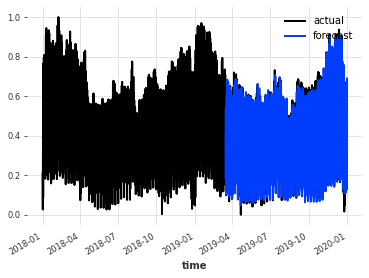

In [27]:
backtest_cov = model_cov.historical_forecasts(series_60_scaled,
                                              past_covariates=covariates_60,
                                              start=0.6,
                                              forecast_horizon=forecast_horizon,
                                              stride=1,
                                              retrain=False,
                                              verbose=True)

series_60_scaled.plot(label='actual')
backtest_cov.plot(label='forecast')
plt.legend();
print('MAPE (using covariates) = {:.2f}%'.format(mape(series_60_scaled, backtest_cov)))

### A few more words on past covariates, future covariates and other conditioning
At the moment Darts supports covariates that are themselves time series. These covariates are used as model inputs, but are never themselves subject to prediction. The covariates do not necessarily have to be aligned with the target series (e.g. they do not need to start at the same time). Darts will use the actual time values of the `TimeSeries` time axes in order to jointly slice the targets and covariates correctly, both for training and inference. Of course the covariates still need to have a sufficient span, otherwise Darts will complain. 

As explained above, `TCNModel`, `NBEATSModel`, `BlockRNNModel`, `TransformerModel` use past covariates (they will complain if you try using `future_covariates`). If these past covariates happen to also be known into the future, then these models are also able to produce forecasts for `n > output_chunk_length` (as shown above for `BlockRNNModel`) in an auto-regressive way.

By contrast, `RNNModel` uses future covariates (it will complain if you try specifying `past_covariates`). This means that prediction with this model requires the covariates (at least) `n` time steps into the future after prediction time.

Past and future covariates (as well as the way they are consummed by the different models) an important but non-trivial topic, and we plan to dedicate a future notebook (or article) to explain this further.

At the time of writing, Darts does not support covariates that are not time series - such as for instance class label informations or other conditioning variables. One trivial (although likely suboptimal) way to go around this is to build time series filled with constant values encoding the class labels. Supporting more general types of conditioning is a future feature on the Darts development roadmap.